In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from datetime import datetime
import mplcyberpunk
from copy import deepcopy as dc

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
# #대한민국 데이터만 추출 후 일자별 확진자 수로 변환
# confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
# korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
# korea.index = pd.to_datetime(korea.index)
# daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
# daily_cases.shape

df = pd.read_csv('./NVDA_110721_Final_1_fdr.csv', index_col=['Date'])
df_X = dc(df[['Close']])
df_y = dc(df[['Close']])

df_X, df_y

(                 Close
 Date                  
 2011/07/21    3.675000
 2011/07/22    3.750000
 2011/07/25    3.690000
 2011/07/26    3.600000
 2011/07/27    3.465000
 ...                ...
 2021/07/14  198.414993
 2021/07/15  189.662506
 2021/07/16  181.610001
 2021/07/19  187.797501
 2021/07/20  186.119995
 
 [2516 rows x 1 columns],
                  Close
 Date                  
 2011/07/21    3.675000
 2011/07/22    3.750000
 2011/07/25    3.690000
 2011/07/26    3.600000
 2011/07/27    3.465000
 ...                ...
 2021/07/14  198.414993
 2021/07/15  189.662506
 2021/07/16  181.610001
 2021/07/19  187.797501
 2021/07/20  186.119995
 
 [2516 rows x 1 columns])

In [3]:
df['Close'].iloc[40]

3.865

In [4]:
def create_sequences(X, y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length):
        _X = X.iloc[i : (i+seq_length)]
        _y = y.iloc[i + seq_length]
        xs.append(_X)
        ys.append(_y)
    return np.array(xs), np.array(ys)

#지도학습용 데이터로 변환
seq_length = 40
X, y = create_sequences(df_X, df_y, seq_length)

In [5]:
X.shape, y.shape

((2476, 40, 1), (2476, 1))

In [6]:
#학습용, 검증용, 시험용으로 분리
train_size = int(X.shape[0] * 0.9)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

X_train.shape, X_val.shape, X_test.shape

((2228, 40, 1), (33, 40, 1), (215, 40, 1))

In [7]:
# # MinMax Scaling
# scaler_x = MinMaxScaler()
# scaler_x.fit(X_train)
# scaler_y = MinMaxScaler()
# scaler_y.fit(y_train)

# X_train = scaler_x.transform(X_train)
# y_train = scaler_y.transform(y_train)

# X_val = scaler_x.transform(X_val)
# y_val = scaler_y.transform(y_val)

# X_test = scaler_x.transform(X_test)
# y_test = scaler_y.transform(y_test)

In [8]:
# MIN = X_train.min()
# MAX = X_train.max()

# def MinMaxScale(array, min, max):
#     return (array - min) / (max - min)

# #MinMax 스케일링
# X_train = MinMaxScale(X_train, MIN, MAX)
# y_train = MinMaxScale(y_train, MIN, MAX)
# X_val = MinMaxScale(X_val, MIN, MAX)
# y_val = MinMaxScale(y_val, MIN, MAX)
# X_test = MinMaxScale(X_test, MIN, MAX)
# y_test = MinMaxScale(y_test, MIN, MAX)

In [9]:
# MAX

NameError: name 'MAX' is not defined

In [10]:
def make_Tensor(array):
    return torch.from_numpy(array).type('torch.FloatTensor')

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [11]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([2228, 40, 1]) torch.Size([33, 40, 1]) torch.Size([215, 40, 1])
torch.Size([2228, 1]) torch.Size([33, 1]) torch.Size([215, 1])


In [12]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred
    

In [13]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None,
    num_epochs=100, verbose=10, patience=10):

    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data):

            model.reset_hidden_state() # seq 별 hidden state reset 

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'''Epoch {t} train loss: {epoch_loss / len(train_data)} 
                    val loss: {val_loss / len(val_data)}''')
            
            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'''Epoch {t} train loss: {epoch_loss / len(train_data)}
                ''')
      
    return model, train_hist, val_hist

In [14]:
model = CovidPredictor(
    n_features=1,
    n_hidden=2,
    seq_len=seq_length,
    n_layers=1
)

model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=1000,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 20.507838934820473 
                    val loss: 112.88346099853516
Epoch 10 train loss: 7.458645534151547 
                    val loss: 84.68392181396484
Epoch 20 train loss: 3.238354128930898 
                    val loss: 68.26748657226562
Epoch 30 train loss: 1.8735050997785434 
                    val loss: 58.690555572509766
Epoch 40 train loss: 1.4768476604987304 
                    val loss: 53.89884567260742
Epoch 50 train loss: 1.323263076841296 
                    val loss: 50.683204650878906
Epoch 60 train loss: 1.196954321069392 
                    val loss: 48.388797760009766
Epoch 70 train loss: 1.1660706000653376 
                    val loss: 46.57646179199219
Epoch 80 train loss: 1.1308004305007429 
                    val loss: 44.89603042602539
Epoch 90 train loss: 1.078159258545408 
                    val loss: 43.14451599121094
Epoch 100 train loss: 1.0291372380308017 
                    val loss: 41.45856857299805
Epoch 110 train loss: 

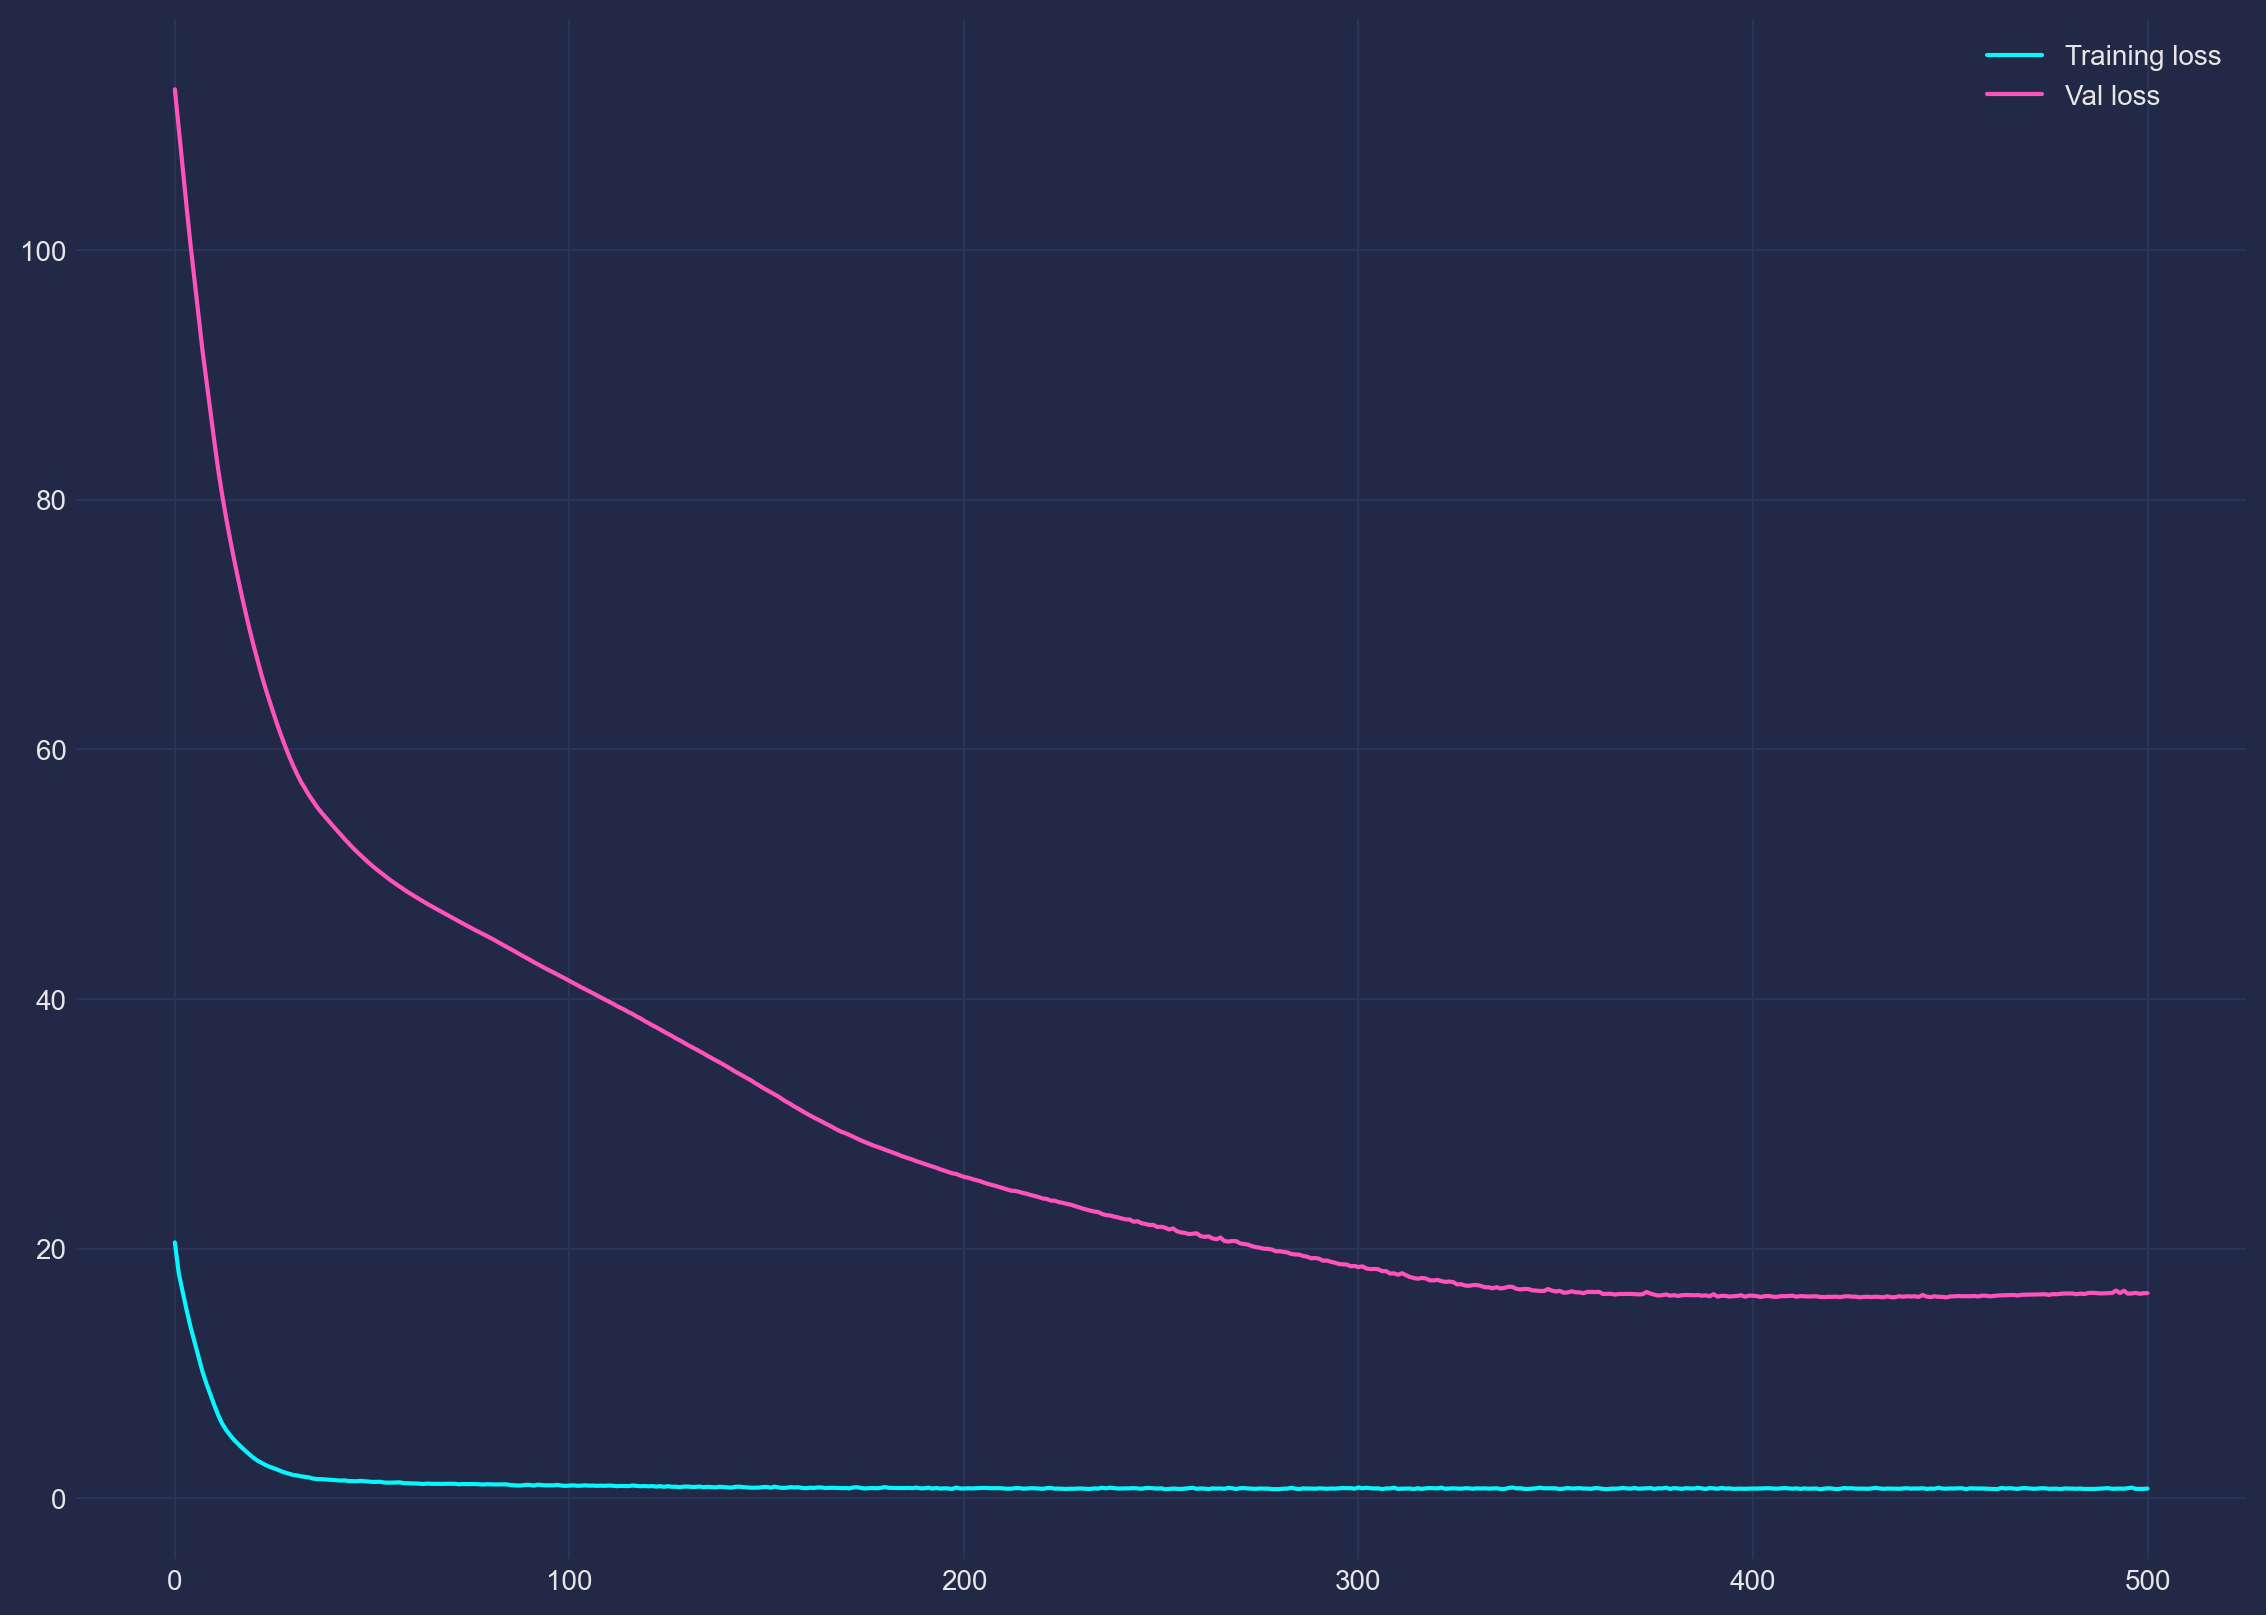

In [15]:
plt.style.use('cyberpunk')
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [16]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)


In [17]:
plt.plot(df_y.index[-len(y_test), ])

AttributeError: 'str' object has no attribute 'ndim'

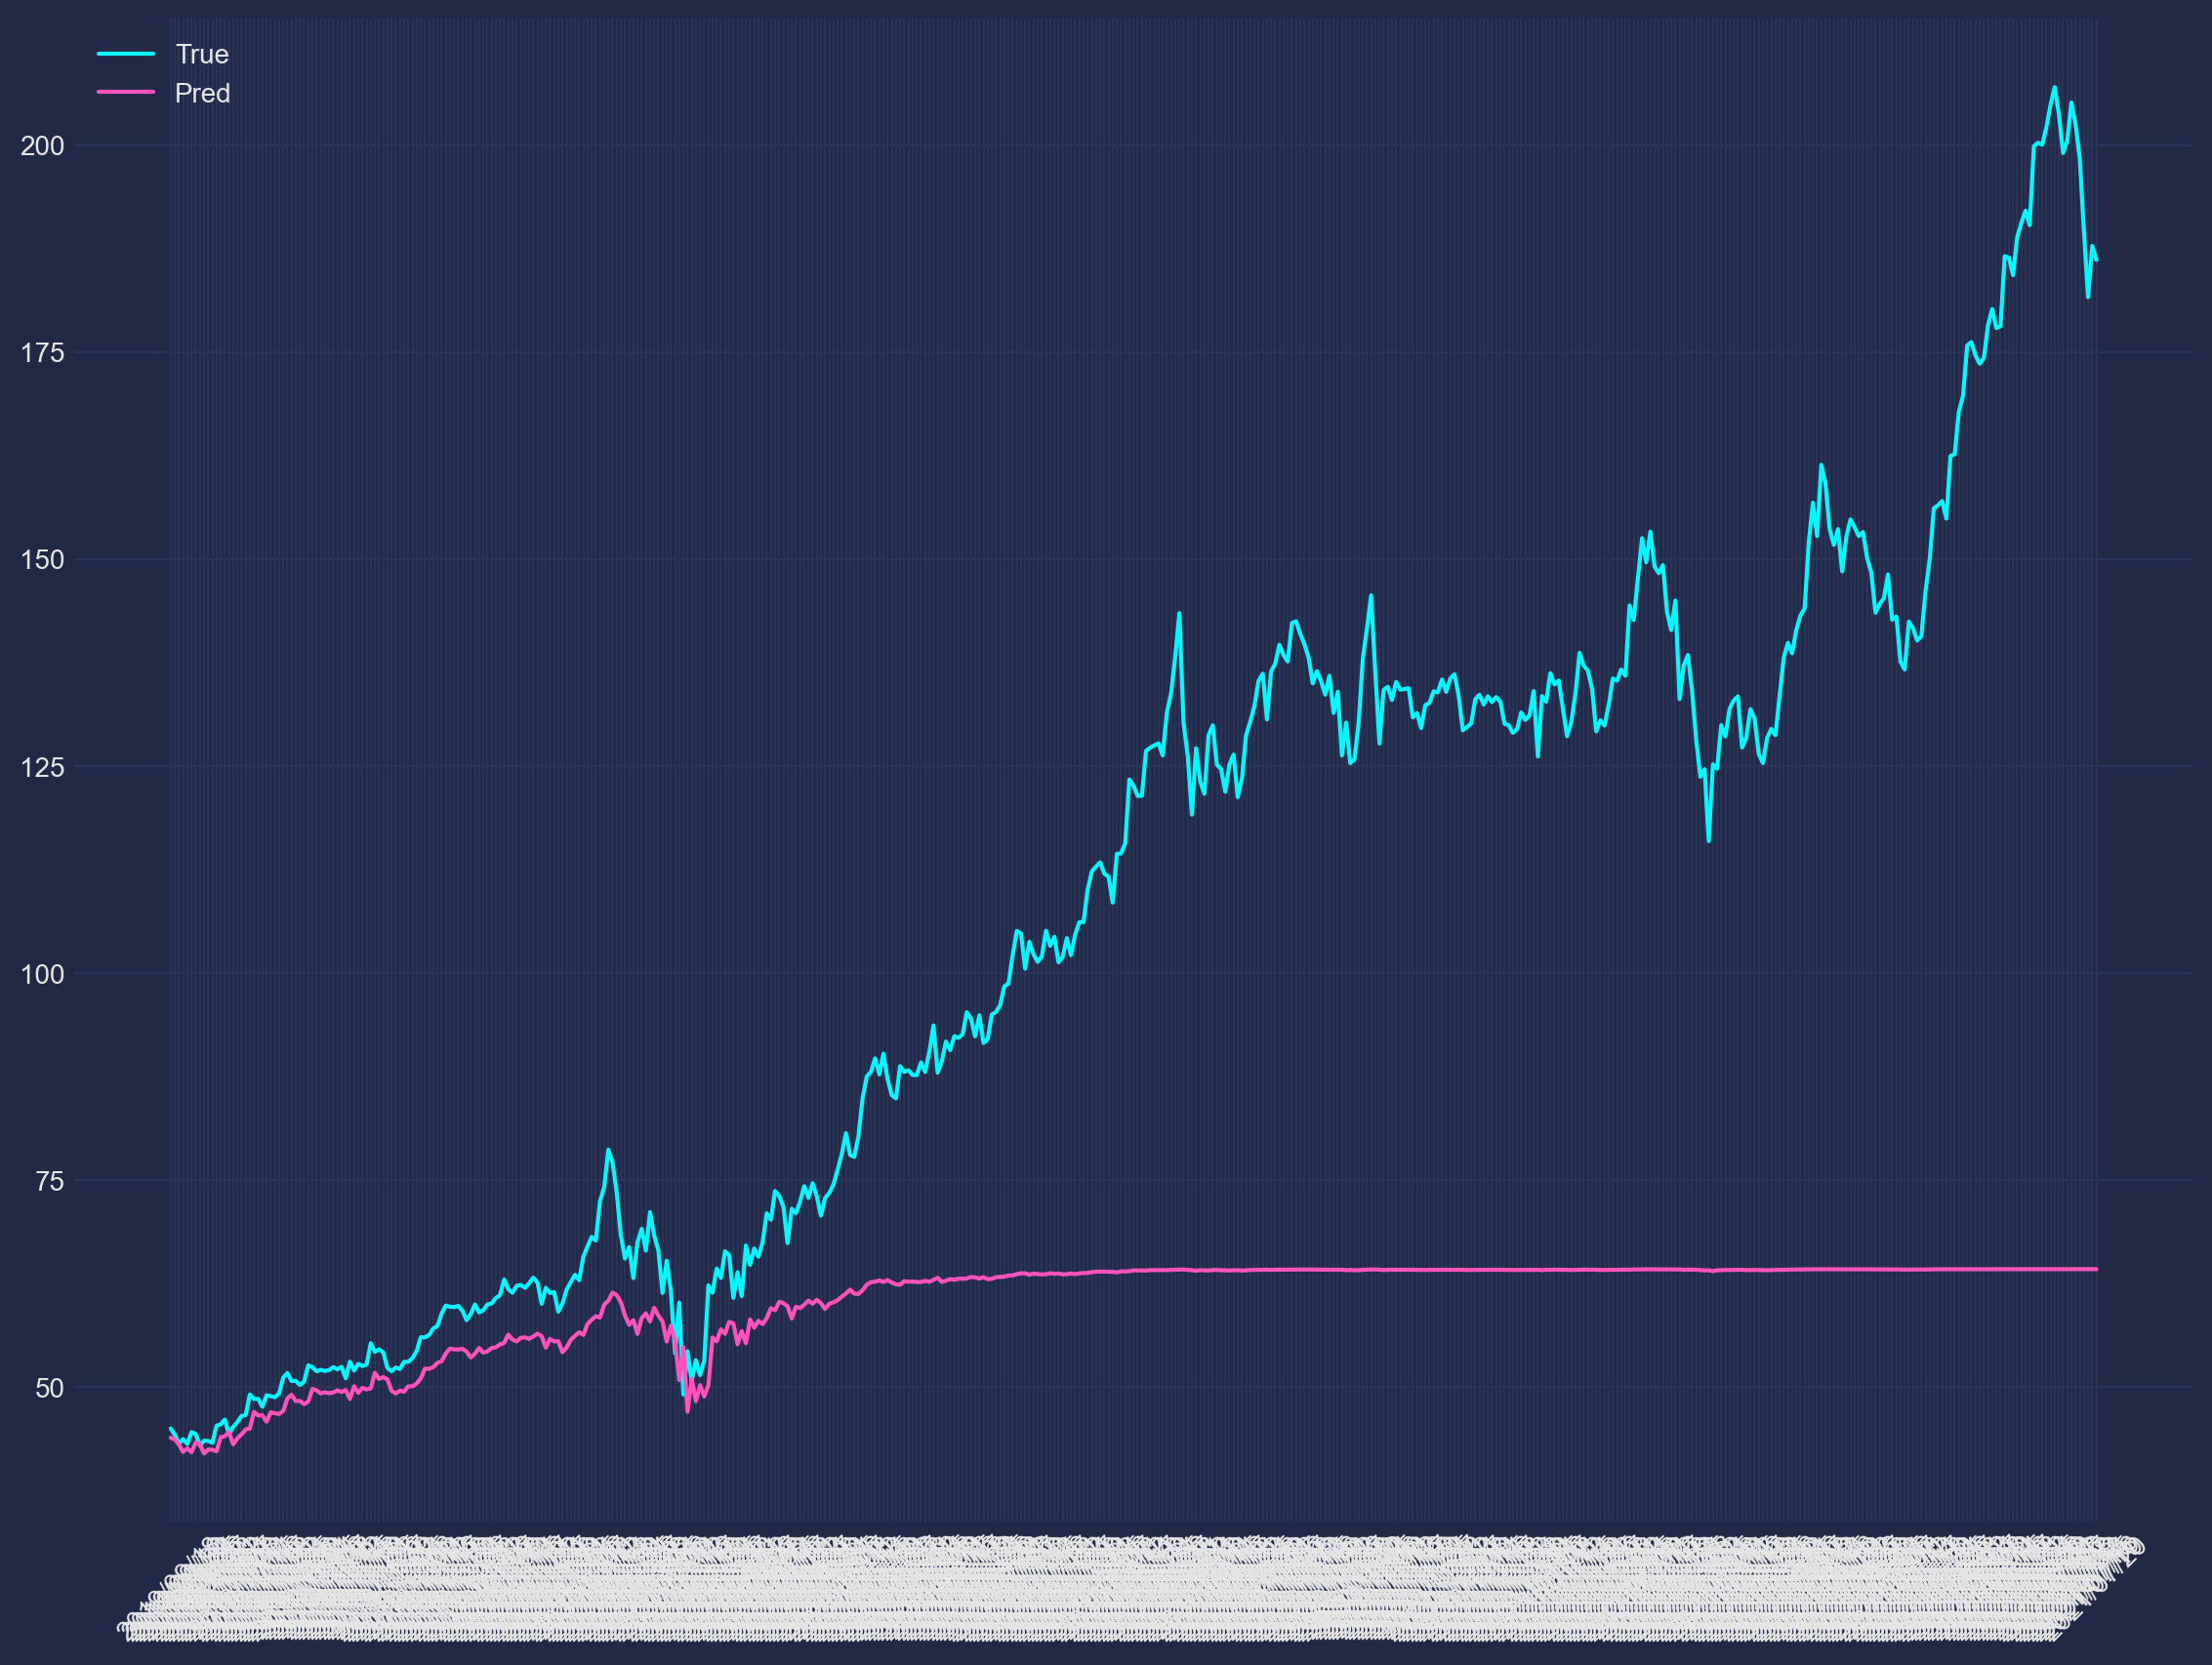

In [ ]:
plt.plot(df_y.index[-len(y_test):], np.array(y_test), label='True')
plt.plot(df_y.index[-len(preds):], np.array(preds), label='Pred')
plt.xticks(rotation=45)
plt.legend()


In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [ ]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)


48.14965277880013

'1.3.2'